# RL Q-learning for cartpole balance

Melissa Mozifian 

Farzaneh Entezari


# n-Step Q-learning
---
4-step SARSA, 4-step Expected SARSA, and 4-step q-learning algorithms with a two layered Neural Network (64 hidden units in each layer) to learn the cartpole balance using OpenAI gym environments.


# Observations
It was found that an $n$-step method is more sensitive to the learning rate $\alpha$. With $1$-step Q-learning, the performance was more stable with various choices of $\alpha$, however as we used the $n$-step rewards, this introduces additional variance and reducing the learning rate in this case helps to stabilize the training significantly.

In terms of exploration, initial value of $\epsilon$ is also crucial as we want the agent to explore but we also want to learn fast and reduce the exploration rate over time to reach a stable convergence. The choice of $\epsilon=0.1$ as starting rate and decaying $1\%$ every $500$ seems to work well.
And of course Q-learning seemed more sensitive to this hyperparameter than say Expected sarsa since it relies on this parameter to select the next potential actions, whereas in Expected Sarsa, we take an average of all actions during the update step.
Overall Expected Sarsa outperforms Q-learning and Sarsa, simply because we are weighing all the actions. So this is expected although for most problems, implementing Expected Sarsa is impractical due to computation reasons, and the fact that we cannot use this in continuous action space. In the case of Cart-pole environment, the difference in terms of performance between Sarsa and Expected Sarsa was negligible and perhaps this is due to the small number of actions we need to consider here, where our action-space comprise of only 2 actions whereas in an environment with larger action-space, it is possible that Expected Sarsa outperforms Sarsa.

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from collections import namedtuple
from collections import deque
from itertools import count
import seaborn
import pandas as pd

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
use_cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() \
    if use_cuda else autograd.Variable(*args, **kwargs)

class ReplayBuffer():

    def __init__(self, capacity):
        self.replay_buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.replay_buffer.append((state, action, reward,
                                   next_state, done))

    def sample(self, batch_size=1):
        state, action, reward, next_state, done = \
            zip(*random.sample(self.replay_buffer, batch_size))
        return np.concatenate(
            state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.replay_buffer)


class nStepQLearning(nn.Module):

    def __init__(self, input_dim, action_space):

        super(nStepQLearning, self).__init__()
        self.action_space = action_space

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_space))

    def forward(self, state):
        return self.layers(state)

    def take_action_no_grad(self, state, epsilon):

        if random.random() > epsilon:
            with torch.no_grad():
                # Don't need gradients for this op
                state = Variable(torch.FloatTensor(state).unsqueeze(0))
                q_value = self.forward(state)
                action = q_value.max(1)[1].cpu().numpy()[0]
        else:
            action = random.randrange(self.action_space)

        return action

    def take_action(self, state, epsilon=0.1):

        if random.random() > epsilon:
            q_value = self.forward(state)
            action = q_value.max(1)[1]
        else:
            action = [random.randrange(self.action_space)
                      for i in range(batch_size)]
            action = Variable(torch.LongTensor(action))

        return action

def compute_TD_loss(replay_buffer, policy_net, 
                    optimizer, batch_size=32, algorithm='q_learning'):

    if len(replay_buffer) < batch_size:
        return

    state, action, reward, next_state, done = replay_buffer.sample(
        batch_size)

    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    state_action_values = policy_net(state)
    next_state_values = policy_net(next_state)

    current_Q_values = state_action_values.gather(
      1, action.unsqueeze(1)).squeeze(1)

    if algorithm == 'q_learning':
      # Q-learning, act greedily w.r.t. current Q-function
      next_state_val_max = next_state_values.max(1)[0]
    elif algorithm == 'sarsa':
        next_action = policy_net.take_action(next_state)
        next_state_val_max = next_state_values.gather(
            1, next_action.unsqueeze(1)).squeeze(1)
    elif algorithm == 'expected_sarsa':
        # Evaluate all actions and take average
        actions = [0, 1]
        next_state_val_max = 0
        for act in actions:
            batch_actions = [act]*batch_size
            next_action = Variable(torch.LongTensor(batch_actions))
            next_state_val_max += next_state_values.gather(
                1, next_action.unsqueeze(1)).squeeze(1)
        next_state_val_max /= len(actions)

    next_Q_values = (1 - done) * next_state_val_max
    target_Q_values = reward + (gamma * next_Q_values)
    # Minimize the Bellman Error
    loss = F.smooth_l1_loss(target_Q_values,
                            current_Q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
##########################
# Training hyperparameters
##########################
gamma = 0.9
batch_size = 32
n_step = 4
num_episodes = 1500

epsilon_start = 0.1
epsilon_final = 0.01
epsilon_decay = 500

def epsilon_by_frame(frame_idx): return epsilon_final + \
    (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)


# Plot settings
width = 6
height = 6
d = 70

# Part 1. Learning Rate vs per Replay Buffer size Returns

In [ ]:
##############################################
# Part 1. Learning rate vs Returns per RB size
##############################################
env = gym.make('CartPole-v0')
s = 1
np.random.seed(s)
env.seed(s)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1]

In [ ]:
def run_training(buffer_size, learning_rate, algorithm='q_learning'):

  print('###############################')
  print('Running Algorithm ', algorithm)
  print('###############################')

  replay_buffer = ReplayBuffer(buffer_size)

  input_dim = env.observation_space.shape[0]
  action_space = env.action_space.n
  policy_net = nStepQLearning(input_dim, action_space).to(use_cuda)

  optimizer = optim.Adam(policy_net.parameters(),lr=learning_rate)

  frame_idx = 0
  console_print = 100

  start_time = time.time()

  losses = []
  all_rewards = []
  last_10_rewards = [0]*10


  for episode in range(num_episodes):

    state, reward, done, episode_reward, ep_len = env.reset(), 0, False, 0, 0

    tau = 0
    state_tau = np.copy(state)
    action_tau = 0
    running_reward = 0

    for t in count():
        # Select epsilon
        epsilon = epsilon_by_frame(episode)

        action = policy_net.take_action_no_grad(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        # Store data for n-step
        if tau < n_step:
            if tau == 0:
                # We need the first state and action
                state_tau = np.copy(state)
                action_tau = action
            # Keep a running average of rewards
            running_reward += gamma**tau * reward
            tau += 1
        if tau == n_step:
            # Now we store (s_0, a_0, avg_discounted_rew, s_n)
            state_n = np.copy(next_state)
            replay_buffer.push(state_tau, action_tau,
                               running_reward, state_n, done)
            # Reset tau
            tau = 0
            running_reward = 0

        state = np.copy(next_state)
        episode_reward += reward
        ep_len += 1

        loss = compute_TD_loss(replay_buffer, policy_net, optimizer,
                               batch_size, algorithm)
        losses.append(loss)

        if done:
          all_rewards.append(episode_reward)
          if episode >= (num_episodes - 10):
            last_10_rewards.append(episode_reward)
          break
    if episode % console_print == 0:
      print('Rewards ', episode_reward, ' for lr ', learning_rate)

  return np.mean(last_10_rewards), all_rewards

In [ ]:
algorithm = 'q_learning'
# Buffer Sizes
rbs = [50, 100, 250, 500] 
# Learning rates
lrs = [0.00001, 0.0001, 0.001]#np.linspace(0.00007, 0.0001, num=10)
per_lrs_and_buffer_rewards = dict()
best_alpha_per_buffer = dict()

for rb in rbs:
  print('Running buffer size ', rb)
  per_lrs_rewards = []
  max_rew = 0
  best_alpha = 0
  for learning_rate in lrs:
    rewards_per_buff, _ = run_training(rb, learning_rate, algorithm)
    # lr_id = 'learning_rate_' + str(learning_rate)
    if rewards_per_buff > max_rew:
      max_rew = rewards_per_buff
      best_alpha = learning_rate
    per_lrs_rewards.append(rewards_per_buff)
  buffer_id = 'BufferSize_' + str(rb)
  per_lrs_and_buffer_rewards.update({buffer_id: per_lrs_rewards})
  best_alpha_per_buffer.update({buffer_id: best_alpha})

Running buffer size  50
###############################
Running Algorithm  q_learning
###############################
Rewards  20.0  for lr  1e-05
Rewards  10.0  for lr  1e-05
Rewards  10.0  for lr  1e-05
###############################
Running Algorithm  q_learning
###############################
Rewards  9.0  for lr  0.0001
Rewards  154.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  q_learning
###############################
Rewards  9.0  for lr  0.001
Rewards  200.0  for lr  0.001
Rewards  198.0  for lr  0.001
Running buffer size  100
###############################
Running Algorithm  q_learning
###############################
Rewards  8.0  for lr  1e-05
Rewards  9.0  for lr  1e-05
Rewards  10.0  for lr  1e-05
###############################
Running Algorithm  q_learning
###############################
Rewards  10.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Runnin

In [ ]:
best_alpha_per_buffer

In [ ]:
###############################
# Learning Rate vs Return Plots
###############################

plt.figure(figsize=(width, height), dpi=d)
plt.xlabel('Learning Rate alpha')
plt.ylabel('Return (last 10 eps)')
plt.title('Q-learning - Learning rate and buffer size')

seaborn.set_style("darkgrid")
plt.legend(loc='upper center', ncol=6, handlelength=1,
            mode="expand", borderaxespad=0., prop={'size': 24})

for lrs_buffer_id, rewards in per_lrs_and_buffer_rewards.items():
  per_lr_rewards = np.asarray(rewards)
  seaborn.lineplot(y=per_lr_rewards, x = lrs, label=lrs_buffer_id)
plt.legend()

![alt text](https://drive.google.com/uc?id=1D7lmU0W0AKpkVsIfZ9Y4_81WYjwUVBYF)


The experiment below was ran over longer iterations, and larger interval of learning rates.


![alt text](https://drive.google.com/uc?id=1XoxDr7wTnDRL5IJEF5H6jqoTtJ140gZa)



Based on these experiments, for Q-learning, as long as learning rate is small enough, the buffer size seems to matter less, however larger buffer size seems to be more stable across various choices of $\alpha$.

Note: These experiments took a bit of time, so we did not run over a larger ranges of alpha for the rest of the methods.


# Observations

SARSA differs from Q-learning in the way the targets are constructed using the policy at hand. This leads to more conservative updates when compared with Q-learning. Using experience replay makes it off-policy but the targets and the updates are still conservative.

In [ ]:
algorithm = 'sarsa'
# Buffer Sizes
rbs = [50, 100, 250, 500] 
# Learning rates
lrs = np.linspace(0.00007, 0.0001, num=10)
per_lrs_and_buffer_rewards = dict()
best_alpha_per_buffer = dict()

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

def epsilon_by_frame(frame_idx): return epsilon_final + \
    (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

for rb in rbs:
  print('Running buffer size ', rb)
  per_lrs_rewards = []
  max_rew = 0
  best_alpha = 0
  for learning_rate in lrs:
    rewards_per_buff, _ = run_training(rb, learning_rate, algorithm)
    # lr_id = 'learning_rate_' + str(learning_rate)
    if rewards_per_buff > max_rew:
      max_rew = rewards_per_buff
      best_alpha = learning_rate
    per_lrs_rewards.append(rewards_per_buff)
  buffer_id = 'BufferSize_' + str(rb)
  per_lrs_and_buffer_rewards.update({buffer_id: per_lrs_rewards})
  best_alpha_per_buffer.update({buffer_id: best_alpha})

In [ ]:
best_alpha_per_buffer

In [ ]:
###############################
# Learning Rate vs Return Plots
###############################

plt.figure(figsize=(width, height), dpi=d)
plt.xlabel('Learning Rate alpha')
plt.ylabel('Return (last 10 eps)')
plt.title('SARSA - Learning rate and buffer size')

seaborn.set_style("darkgrid")
plt.legend(loc='upper center', ncol=6, handlelength=1,
            mode="expand", borderaxespad=0., prop={'size': 24})

for lrs_buffer_id, rewards in per_lrs_and_buffer_rewards.items():
  per_lr_rewards = np.asarray(rewards)
  seaborn.lineplot(y=per_lr_rewards, x = lrs, label=lrs_buffer_id)
plt.legend()

![alt text](https://drive.google.com/uc?id=16Hsy0xWwCzbFPaLpQBT7A3Lt6XcYKipO)

In [ ]:
algorithm = 'expected_sarsa'
# Buffer Sizes
rbs = [50, 100, 250, 500] 
# Learning rates
lrs = np.linspace(0.00001, 0.0001, num=10)
per_lrs_and_buffer_rewards = dict()
best_alpha_per_buffer = dict()

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

def epsilon_by_frame(frame_idx): return epsilon_final + \
    (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

for rb in rbs:
  print('Running buffer size ', rb)
  per_lrs_rewards = []
  max_rew = 0
  best_alpha = 0
  for learning_rate in lrs:
    rewards_per_buff, _ = run_training(rb, learning_rate, algorithm)
    # lr_id = 'learning_rate_' + str(learning_rate)
    if rewards_per_buff > max_rew:
      max_rew = rewards_per_buff
      best_alpha = learning_rate
    per_lrs_rewards.append(rewards_per_buff)
  buffer_id = 'BufferSize_' + str(rb)
  per_lrs_and_buffer_rewards.update({buffer_id: per_lrs_rewards})
  best_alpha_per_buffer.update({buffer_id: best_alpha})

In [ ]:
best_alpha_per_buffer

In [ ]:
###############################
# Learning Rate vs Return Plots
###############################

plt.figure(figsize=(width, height), dpi=d)
plt.xlabel('Learning Rate alpha')
plt.ylabel('Return (last 10 eps)')
plt.title('Expected SARSA - Learning rate and buffer size')

seaborn.set_style("darkgrid")
plt.legend(loc='upper center', ncol=6, handlelength=1,
            mode="expand", borderaxespad=0., prop={'size': 24})

for lrs_buffer_id, rewards in per_lrs_and_buffer_rewards.items():
  per_lr_rewards = np.asarray(rewards)
  seaborn.lineplot(y=per_lr_rewards, x = lrs, label=lrs_buffer_id)
plt.legend()

Interestingly, Expected Sarsa seems to be more sensitive to the choices of buffer size and still favours lower learning rate. For the next part of the experiment, we are going to select a smaller buffer size.


![alt text](https://drive.google.com/uc?id=1MIOMvHDbMXEhqHcs2g-WwB7CAt5OlHSd)

# Part 2. Best learning rate and buffer size over 20 seeds

In [ ]:
# Run over 20 random seeds
seeds = [random.randint(0, 10) for iter in range(20)]

buffer_size = 500
learning_rate = 0.0001
num_episodes = 1500
algorithm = 'q_learning'

rewards_over_seeds = []

for s in seeds:
  env = gym.make('CartPole-v0')
  np.random.seed(s)
  env.seed(s)
  _, rewards = run_training(buffer_size, learning_rate, algorithm)
  rewards_over_seeds.append(rewards)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


###############################
Running Algorithm  q_learning
###############################
Rewards  10.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  q_learning
###############################
Rewards  10.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  q_learning
###############################
Rewards  11.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  197.0  for lr  0.0001
###############################
Running Algorithm  q_learning
###############################
Rewards  19.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  q_learning
###############################
Rewards  10.0  for lr  0.0001
Rewards  10.0  for lr  0.0001
Rewards  16.0  for lr  0.0001
###############################
Running Algorithm  q_learning
##########

No handles with labels found to put in legend.


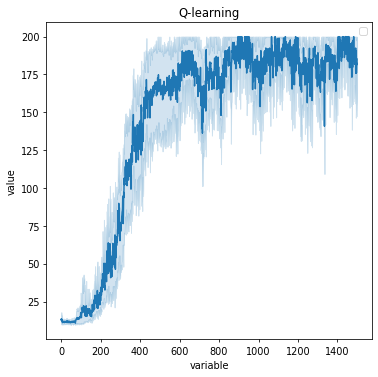

In [ ]:
###############################
# Returns over 20 random seeds
###############################
rewards_over_seeds = np.asarray(rewards_over_seeds)
plt.figure(figsize=(width, height), dpi=d)
plt.xlabel('Episode')
plt.ylabel('Returns')
plt.title('Q-learning')


df = pd.DataFrame(rewards_over_seeds).melt()
seaborn.lineplot(x="variable", y="value", data=df)

#seaborn.lineplot(data=rewards_over_seeds)
plt.legend()

In [ ]:
# Run over 20 random seeds
seeds = [random.randint(0, 10) for iter in range(20)]

buffer_size = 500
learning_rate = 0.0001
num_episodes = 1500
algorithm = 'sarsa'

rewards_over_seeds = []

for s in seeds:
  env = gym.make('CartPole-v0')
  np.random.seed(s)
  env.seed(s)
  _, rewards = run_training(buffer_size, learning_rate, algorithm)
  rewards_over_seeds.append(rewards)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


###############################
Running Algorithm  sarsa
###############################
Rewards  9.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  sarsa
###############################
Rewards  9.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  sarsa
###############################
Rewards  9.0  for lr  0.0001
Rewards  145.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  sarsa
###############################
Rewards  22.0  for lr  0.0001
Rewards  144.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  sarsa
###############################
Rewards  10.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
Rewards  200.0  for lr  0.0001
###############################
Running Algorithm  sarsa
###############################
Rewards  

No handles with labels found to put in legend.


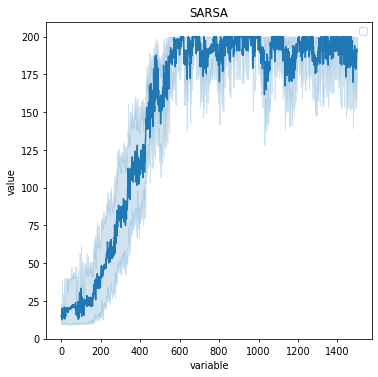

In [ ]:
###############################
# Returns over 20 random seeds
###############################
rewards_over_seeds = np.asarray(rewards_over_seeds)
plt.figure(figsize=(width, height), dpi=d)
plt.xlabel('Episode')
plt.ylabel('Returns')
plt.title('SARSA')


df = pd.DataFrame(rewards_over_seeds).melt()
seaborn.lineplot(x="variable", y="value", data=df)

#seaborn.lineplot(data=rewards_over_seeds)
plt.legend()

# Observations

For Expected Sarsa, smaller buffer size seems to work better.
Perhaps this is because since we are considering all the actions, its better to have most recent data as opposed to relying on earlier policies. For the following plot, we picked a buffer size of $250$, but it might be that even a smaller buffer size is a better choice in thise case since we still observe some high variance compared to Sarsa.

In [ ]:
# Run over 20 random seeds
seeds = [random.randint(0, 10) for iter in range(20)]

buffer_size = 250
learning_rate = 0.0006
num_episodes = 1500
algorithm = 'expected_sarsa'

epsilon_start = 0.1
epsilon_final = 0.01
epsilon_decay = 500

def epsilon_by_frame(frame_idx): return epsilon_final + \
    (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

rewards_over_seeds = []

for s in seeds:
  env = gym.make('CartPole-v0')
  np.random.seed(s)
  env.seed(s)
  _, rewards = run_training(buffer_size, learning_rate, algorithm)
  rewards_over_seeds.append(rewards)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


###############################
Running Algorithm  expected_sarsa
###############################
Rewards  9.0  for lr  0.0006
Rewards  8.0  for lr  0.0006
Rewards  21.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  46.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
###############################
Running Algorithm  expected_sarsa
###############################
Rewards  11.0  for lr  0.0006
Rewards  10.0  for lr  0.0006
Rewards  21.0  for lr  0.0006
Rewards  46.0  for lr  0.0006
Rewards  26.0  for lr  0.0006
Rewards  53.0  for lr  0.0006
Rewards  53.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  123.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  200.0  for lr  0.0006
Rewards  20

No handles with labels found to put in legend.


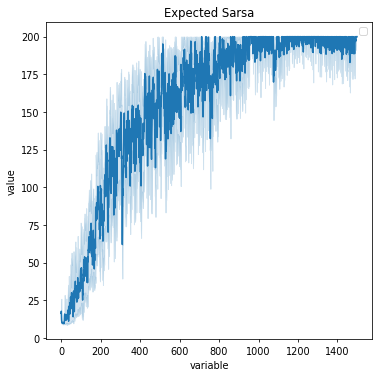

In [ ]:
###############################
# Returns over 20 random seeds
###############################
rewards_over_seeds = np.asarray(rewards_over_seeds)
plt.figure(figsize=(width, height), dpi=d)
plt.xlabel('Episode')
plt.ylabel('Returns')
plt.title('Expected Sarsa')


df = pd.DataFrame(rewards_over_seeds).melt()
seaborn.lineplot(x="variable", y="value", data=df)

plt.legend()